In [21]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import pytorch_lightning as pl
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
directories = ['/mnt/disks/pancan/data/' + x for x in os.listdir('/mnt/disks/pancan/data/') if 'tcga_pan_can_atlas' in x]

In [23]:
def load_single_dataset(directory_path):
    rna_exp = pd.read_csv(directory_path + '/data_mrna_seq_v2_rsem.txt',
                           sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    rna_exp = rna_exp.loc[:,~rna_exp.columns.duplicated()].astype(float).copy()
    cna = pd.read_csv(directory_path + '/data_cna.txt',
                      sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    cna.drop('Cytoband', errors='ignore', inplace=True)
    cna = cna.loc[:,~cna.columns.duplicated()].astype(float).copy()
    
    genes = list(set(rna_exp.columns).intersection(cna.columns))
    indices = list(set(rna_exp.index).intersection(cna.index))
    tumor_type = pd.DataFrame(len(indices)*[directory_path.split('/')[-1].split('_')[0]],
                              index = indices, columns=['tumor'])
    return rna_exp[genes], cna[genes], tumor_type

In [24]:
rna, cna, tumor = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for path in directories:
    rna_, cna_, tumor_ = load_single_dataset(path)
    rna = pd.concat([rna_, rna])
    cna = pd.concat([cna_, cna])
    tumor = pd.concat([tumor_, tumor])
    
rna.dropna(axis=1, inplace=True)
cna.dropna(axis=1, inplace=True)
rna = (rna-rna.mean())/rna.std()


In [25]:

genetic_data = {'rna': rna, 'cna': cna}

In [26]:
absolute_TCGA = pd.read_csv('/mnt/disks/pancan/data/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt',
                            delimiter='\t', index_col='array')
absolute_ploidy = absolute_TCGA[['ploidy']].join(rna, how='inner')['ploidy']
absolute_ploidy.dropna(inplace=True)

In [27]:
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_ploidy.values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_ploidy.max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_ploidy.max(),1000)[y[:,1] < 0.5].max()
absolute_ploidy_y = pd.DataFrame(index=absolute_ploidy.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in absolute_ploidy.values])

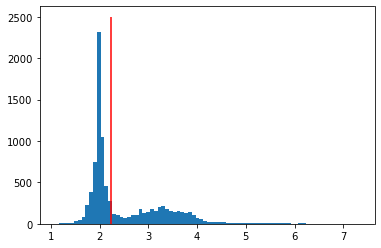

In [28]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(absolute_ploidy, bins=80)
plt.vlines([ma], color='r', ymin=0, ymax=2500)
plt.savefig('ploidy_cutoff_selection.pdf')
plt.show()

In [29]:
pca = PCA(n_components=50)
pca.fit(rna.values)

PCA(n_components=50)

In [30]:
pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=rna.columns)

In [31]:
genes_pca = abs(pca_loadings).sum(axis=1).nlargest(1000).index

In [32]:
genetic_data = {'rna': rna[genes_pca], 'cna': cna}

In [33]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, absolute_ploidy_y)

Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (6304, 2000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (2701, 2000)


In [34]:
import ReactomeNetwork

In [35]:
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

Found 1000 overlapping genes


In [36]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 64)

In [37]:
import torch.nn as nn
import torch.nn.functional as F


In [38]:
class simple_model(pl.LightningModule):
    def __init__(self, gene_list, nbr_gene_inputs):
        super().__init__()
        input_dim = len(gene_list)*nbr_gene_inputs
        
        self.input_layer = nn.Linear(input_dim, 100)
        self.output_layer = nn.Linear(100, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.input_layer(x))
        x = self.output_layer(x)
        return x

    
    def step(self, who, batch, batch_nb):
        x, additional, y = batch
        pred_y = self(x)
        loss = F.binary_cross_entropy_with_logits(pred_y, y, reduction='mean')

        self.log(who + '_bce_loss', loss)
        return loss
    
    def training_step(self, batch, batch_nb):
        # REQUIRED
        loss = self.step('train', batch, batch_nb)
        return loss

    def validation_step(self, batch, batch_nb):
        loss = self.step('val', batch, batch_nb)
        return loss

    def test_step(self, batch, batch_nb):
        loss = self.step('test', batch, batch_nb)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [39]:
model = simple_model(reactome_network.gene_list, len(genetic_data))

In [40]:
trainer = pl.Trainer(precision=16, accelerator='cuda', max_epochs=100, log_every_n_steps=50, 
                     enable_checkpointing=True)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type   | Params
----------------------------------------
0 | input_layer  | Linear | 200 K 
1 | output_layer | Linear | 101   
----------------------------------------
200 K     Trainable params
0         Non-trainable params
200 K     Total params
0.400     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
model

In [ ]:
class lightning_test_dataset(Dataset):
    def __init__(self, shape):
        self.x = torch.rand(shape)
        self.y = torch.rand(shape[0],1).round()
        self.input_df = pd.DataFrame(self.x)
        self.target = pd.DataFrame(self.y)
        self.additional = torch.tensor(pd.DataFrame(index=self.input_df.index).values)
        
    def __len__(self):
        return self.input_df.shape[0]

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        additional = self.additional[index]
        return x, additional, y

In [ ]:
train_loader, test_loader = pnet_loader.to_dataloader(lightning_test_dataset((1000, 1998)), lightning_test_dataset((1000, 1998)), 64)

In [ ]:
trainer = pl.Trainer(precision='bf16', accelerator='cuda', max_epochs=100, log_every_n_steps=50, 
                     enable_checkpointing=True)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,)